# UAVSAR

```{admonition} Learning Objectives
*A 30 minute guide to UAVSAR data for SnowEX*
- overview of UAVSAR data (both InSAR and PolSAR products)
- demonstrate how to access and transform data
- use Python rasterio and matplotlib to display the data
```

<img src="../../img/UAVSAR_plane.jpg" alt="uavsar airplane" width="800px">

*Developers: \
Jack Tarricone, University of Nevada, Reno \
Zach Keskinen, Boise State University*

*Other developers: \
Ross Palomaki, Montana State University\
Naheem Adebisi, Boise State University*

In [12]:
import sys
import os
import glob
import numpy as np
import uavsar_pytools
import matplotlib.pyplot as plt
import rasterio as rio
from osgeo import gdal
from rasterio.plot import show

## What is UAVSAR?

UAVSAR stands for uninhabited aerial vehicle synthetic aperture radar. It is a suborbital (airplane) remote sensing instrument operated out of NASA JPL.

| frequency (cm) | resolution (rng x azi m) | swath width (km) |
| - | - | - | 
| L-band 23| 1.8 x 5.5 | 16 | 

Documentation:
* https://uavsar.jpl.nasa.gov/education/what-is-uavsar.html
* https://asf.alaska.edu/data-sets/sar-data-sets/uavsar/
* https://ieeexplore-ieee-org.unr.idm.oclc.org/document/1631770 (Rosen et al. 2006)


## NASA SnowEx 2020 and 2021 UAVSAR Campaings

During the winter of 2020 and 2021, NASA conducted an L-band InSAR timeseris at a seris of sites across the Western US with the goal of tracking changes in SWE. Field teams in 13 different locations in 2020, and in 6 locations in 2021, deployed on the date of the flight to perform calibration and validation observations.

:::{figure-md} UAVSAR-map
<img src="../../img/SnowEx2020.png" alt="uavsar map" width="800px">

Map of the UAVSAR flight locations for NASA SnowEx. Source: Chris Hiemstra
:::

## Data Access

There are multiple ways to access UAVSAR data. Also the SQL database.

* [JPL UAVSAR Data Search](https://uavsar.jpl.nasa.gov/cgi-bin/data.pl)
* [Alaska Satellite Facility Vertex Portal](https://search.asf.alaska.edu/#/?dataset=UAVSAR)

```{admonition} InSAR Data Types
:class: InSAR Data Types
- ANN file (.ann): a text annotation file with metadata
- AMP files (.amp1 and .amp2): calibrated multi-looked amplitude products
- INT files (.int): interferogram product, complex number format (we won't be using these here)
- COR files (.cor): interferometric correlation product, a measure of the noise level of the phase
- GRD files (.grd): interferometric products projected to the ground in simple geographic coordinates (latitude, longitude)
- HGT file  (.hgt): the DEM that was used in the InSAR processing
- KML and KMZ files (.kml or .kmz): format for viewing files in Google Earth (can't be used for analysis)
```

## Data Download and Conversion with ```uavsar_pytools```
Using the ```uavsar_pytools``` package, we'll now download the data. The zip file URL contains multiple datasets, so we'll use the ```UavsarScence``` function. The data traditionally comes in a binary format, which is not injestible by tradtional geospatial analysis software (Python, R, QGIS, ArcGIS). ```uavsar_pytools``` nativiely downloads, formats, and converts this data in analysis ready rasters projected in WSG-84 Lat/Lon (maybe more infor here).

To use it, you just need to input your url into the ```UavsarScene``` function, and a path to where you want the data output to be. Once that object is created, use the ```url_to_tiffs``` funciton to begin the process. Data has to download, but there's a progress bar to keep tabs. Once the data is downloaded the conversion happens within a miniute or so.

Or you can use https://search.asf.alaska.edu/ to find a url through their vertex interface.

In [10]:
# define function inputs
path_to_zip = 'https://datapool.asf.alaska.edu/INTERFEROMETRY_GRD/UA/Ncarag_12801_14037-004_15018-003_0336d_s01_L090_01_int_grd.zip'
saving_location = '/Users/jacktarricone/Desktop/nica'

In [11]:
# download and convert data
from uavsar_pytools import UavsarScene
scene = UavsarScene(url = path_to_zip, work_dir = saving_location)
scene.url_to_tiffs()

Unzipping: 100%|█████████████████████████████████████████████████| 4/4 [00:17<00:00,  4.26s/file]


In [15]:
# print list of .tifs we just created 
os.chdir('/Users/jacktarricone/Desktop/nica/Ncarag_12801_14037-004_15018-003_0336d_s01_L090_01_int_grd/')
for files in glob.glob("*.tiff"):
    print(files)

Ncarag_12801_14037-004_15018-003_0336d_s01_L090HH_01.cor.grd.tiff
Ncarag_12801_14037-004_15018-003_0336d_s01_L090HH_01.int.grd.tiff
Ncarag_12801_14037-004_15018-003_0336d_s01_L090HH_01.hgt.grd.tiff


/Users/jacktarricone/opt/miniconda3/envs/hackweek/lib/python3.10/site-packages/uavsar_pytools/uavsar_image.py:89: FutureWarning: elementwise != comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  if self.arr != None:


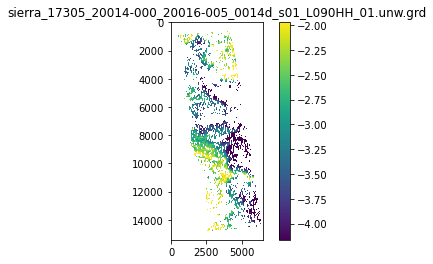

In [18]:
# define outpout dir and list files
from uavsar_pytools import UavsarImage
os.chdir('/Users/jacktarricone/Desktop/nica/')
single_url = 'https://unzip.asf.alaska.edu/INTERFEROMETRY_GRD/UA/sierra_17305_20014-000_20016-005_0014d_s01_L090_01_int_grd.zip/sierra_17305_20014-000_20016-005_0014d_s01_L090HH_01.unw.grd'
image = UavsarImage(url = single_url, work_dir = './data/imgs/')
image.url_to_tiff()

In [20]:
# unwrapped phase
for unw in glob.glob("/Users/jacktarricone/Desktop/nica/data/imgs/sierra_17305_20014-000_20016-005_0014d_s01_L090HH_01.unw.grd.tiff"):
    print(unw)

/Users/jacktarricone/Desktop/nica/data/imgs/sierra_17305_20014-000_20016-005_0014d_s01_L090HH_01.unw.grd.tiff


In [21]:
# open raster and inspect meta data
unw_rast = rio.open(unw)
meta_data = unw_rast.profile
print(meta_data)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 6485, 'height': 15420, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(5.556e-05, 0.0, -119.16764376,
       0.0, -5.556e-05, 37.83863796), 'tiled': False, 'interleave': 'band'}


In [25]:
# convert to np.array for plotting
with rio.open(unw) as unw_raw:
    unw_array = unw_raw.read(1)

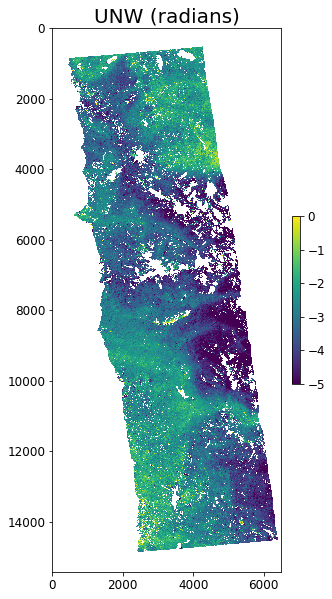

In [31]:
# plot
plt.rcParams.update({'font.size': 12}) # increase plot font size for larger plot
fig, ax = plt.subplots(figsize=(5, 10))

ax.set_title("UNW (radians)", fontsize= 20) #title and font size
img = ax.imshow(unw_array, cmap = 'viridis', interpolation = 'nearest', vmin = -5, vmax = 0)

# add legend
colorbar = fig.colorbar(img, ax=ax, fraction=0.03, pad=0.04) # add color bar
plt.show()
plt.rcParams.update({'font.size': 12}) # change font back to normal